In [2]:
# !pip3 install boto3

In [3]:
import base64
import boto3
import json
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [6]:
FIG_SIZE = (12, 8)
image_file='people_car.jpg'

REGION='us-west-2'

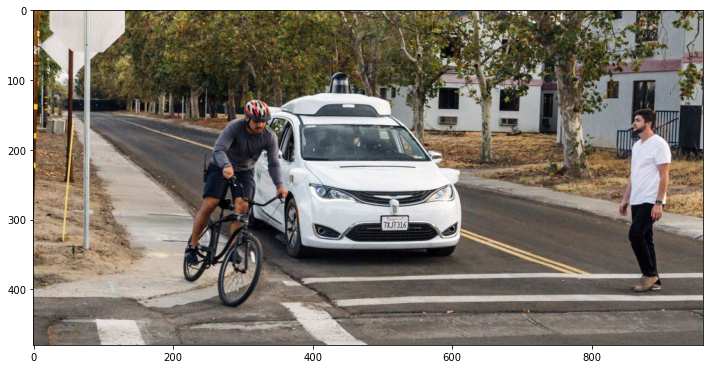

In [11]:
img = plt.imread(image_file)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

In [7]:
client=boto3.client('rekognition', region_name=REGION)

In [8]:
%%time
with open(image_file, 'rb') as image:
    try:
        response = client.detect_labels(Image={'Bytes': image.read()})
    except Exception as exc:
        print(exc)

CPU times: user 184 ms, sys: 35.5 ms, total: 220 ms
Wall time: 2.83 s


In [9]:
def get_objects(response: str) -> dict:
    """Parse the data, returning detected objects only."""
    return {
        label["Name"].lower(): round(label["Confidence"], 1)
        for label in response["Labels"]
        if len(label["Instances"]) > 0
    }

In [10]:
get_objects(response)

{'person': 99.9, 'bicycle': 99.9, 'wheel': 99.5, 'car': 99.4, 'shoe': 97.6}